In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # General plotting
import seaborn as sns # Scatterplots and Histograms


In [ ]:
os.chdir('/gpfs/home/djs19ctu/ML_project/anage_all_data_nogen')
os.getcwd()

'/gpfs/home/djs19ctu/ML_project/anage_all_data_nogen'

In [ ]:
contents = os.listdir(os.getcwd())

print("Contents of the current working directory:")
for item in contents:
    print(item)

Contents of the current working directory:
data_exploration_general.ipynb
CatBoost_nogen.ipynb
databases
hpcdebug
param_search_cb_withQuality.py
previous_analysis
mammal_data_filtered.csv
correlation_plots.ipynb
manuscript_plots_PathAnalysisData.ipynb
Hyperparameter_search.ipynb
.ipynb_checkpoints
test_mammal_data_imputed_nogen.csv
param_search_cb_withQuality-1034896.out
1
mammal_data_imputed_nogen.csv
2. database_impute.ipynb
figures
hpcadmin.sub
train_mammal_data_imputed_nogen.csv
catboost_param_results_nogen.txt
mammal_data.csv
manuscript_plots.ipynb
catboost_info
param_search_cb_withQuality-1034896.err
1. database_prepare_explore.ipynb
run_param_search_cb_withQuality.sh


In [ ]:
train_df_imputed = pd.read_csv('train_mammal_data_imputed_nogen.csv')
test_df_imputed = pd.read_csv('test_mammal_data_imputed_nogen.csv')

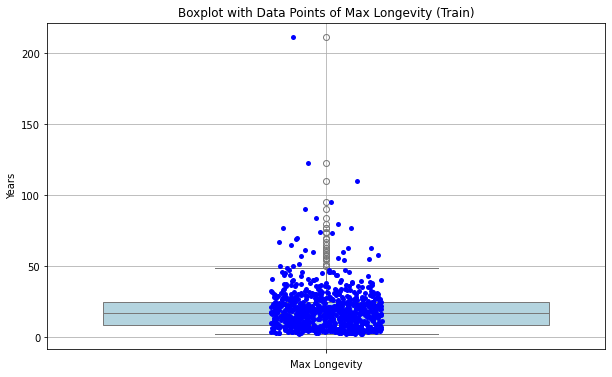

In [ ]:


plt.figure(figsize=(10, 6))
sns.boxplot(y=train_df_imputed['maximum longevity (yrs)'], color='lightblue')
sns.stripplot(y=train_df_imputed['maximum longevity (yrs)'], color='blue', jitter=True, size=5)
plt.xlabel('Max Longevity')
plt.ylabel('Years')
plt.title('Boxplot with Data Points of Max Longevity (Train)')
plt.grid(True)
plt.show()


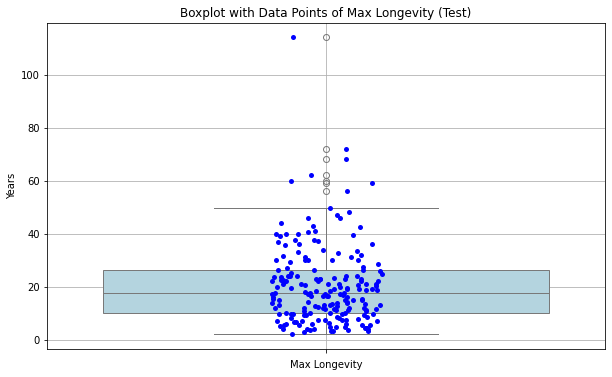

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=test_df_imputed['maximum longevity (yrs)'], color='lightblue')
sns.stripplot(y=test_df_imputed['maximum longevity (yrs)'], color='blue', jitter=True, size=5)
plt.xlabel('Max Longevity')
plt.ylabel('Years')
plt.title('Boxplot with Data Points of Max Longevity (Test)')
plt.grid(True)
plt.show()

In [ ]:
try:
    import sklearn
    print(f"scikit-learn version: {sklearn.__version__}")
    print("scikit-learn imported successfully!")
except ImportError as e:
    print("Error importing scikit-learn:", e)

scikit-learn version: 0.22.2
scikit-learn imported successfully!


In [ ]:
# Display the shapes of the resulting datasets
print(f"Training data shape: {train_df_imputed.shape}")
print(f"Testing data shape: {test_df_imputed.shape}")

Training data shape: (776, 23)
Testing data shape: (194, 23)


In [ ]:

# Best Model: <catboost.core.CatBoostRegressor object at 0x2b679e224ac8>
#Best Parameters: {'cat_features': ['order', 'family', 'genus'],
#'depth': 5, 'iterations': 759, 'l2_leaf_reg': 6.52, 'learning_rate': 0.08}

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# Define the features and target
features = ['order', 'family', 'genus',
            'adult_mass_g', 'adult_brain_mass_g',
            'female_maturity_d', 'gestation_length_d',
            'litter_size_n', 'litters_per_year_n',
            'weaning_age_d',
            'hibernation_torpor',
            'trophic_level', 'activity_cycle',
            'freshwater', 'marine', 'terrestrial_non-volant', 'terrestrial_volant', 'habitat_breadth_n',
            'specimen origin']

target = 'maximum longevity (yrs)'

data_train = train_df_imputed.copy()

X = data_train[features].copy()
y = data_train[target]


# Identify categorical features
categorical_features = ['order', 'family', 'genus', 'specimen origin']

# Convert categorical features to category type
for col in categorical_features:
    X[col] = X[col].astype('category')

# Initialize CatBoost Regressor
model_CatBoost = CatBoostRegressor(
    loss_function='RMSE',
    iterations=759,
    learning_rate=0.08,
    depth=5,
    l2_leaf_reg=6.52,
    cat_features=categorical_features,
    verbose=100,
    bootstrap_type='Bayesian',
    thread_count=-1)

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores = []
cv_mae_scores = []
cv_rmse_scores = []

for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    train_pool_cv = Pool(data=X_train_cv, label=y_train_cv, cat_features=categorical_features)
    val_pool_cv = Pool(data=X_val_cv, label=y_val_cv, cat_features=categorical_features)

    model_CatBoost.fit(train_pool_cv, eval_set=val_pool_cv, early_stopping_rounds=50, verbose=False)

    y_val_pred = model_CatBoost.predict(val_pool_cv)
    r2_cv = r2_score(y_val_cv, y_val_pred)
    mae_cv = mean_absolute_error(y_val_cv, y_val_pred)
    rmse_cv = np.sqrt(mean_squared_error(y_val_cv, y_val_pred))

    cv_r2_scores.append(r2_cv)
    cv_mae_scores.append(mae_cv)
    cv_rmse_scores.append(rmse_cv)

# Calculate the mean and standard deviation of the scores
mean_cv_r2 = np.mean(cv_r2_scores)
std_cv_r2 = np.std(cv_r2_scores)
mean_cv_mae = np.mean(cv_mae_scores)
std_cv_mae = np.std(cv_mae_scores)
mean_cv_rmse = np.mean(cv_rmse_scores)
std_cv_rmse = np.std(cv_rmse_scores)

print(f"Mean Cross-Validation R-squared score: {mean_cv_r2:.4f}")
print(f"Standard Deviation of Cross-Validation R-squared score: {std_cv_r2:.4f}")
print(f"Mean Cross-Validation MAE: {mean_cv_mae:.4f}")
print(f"Standard Deviation of Cross-Validation MAE: {std_cv_mae:.4f}")
print(f"Mean Cross-Validation RMSE: {mean_cv_rmse:.4f}")
print(f"Standard Deviation of Cross-Validation RMSE: {std_cv_rmse:.4f}")

# Check the MAE and Rsquare on Test and Train set

predictions_train = model_CatBoost.predict(data_train[features])
mae_train = mean_absolute_error(data_train[target], predictions_train)
print(f"Training Mean Absolute Error: {mae_train}")
r2_train = r2_score(data_train[target], predictions_train)
print(f"Training R-squared: {r2_train}")

data_test = test_df_imputed.copy()
predictions_test = model_CatBoost.predict(data_test[features])
mae_test = mean_absolute_error(data_test[target], predictions_test)
r2_test = r2_score(data_test[target], predictions_test)

print(f"testing Mean Absolute Error: {mae_test}")
print(f"Testing R-squared: {r2_test}")


Mean Cross-Validation R-squared score: 0.7952
Standard Deviation of Cross-Validation R-squared score: 0.0828
Mean Cross-Validation MAE: 4.1956
Standard Deviation of Cross-Validation MAE: 0.8250
Mean Cross-Validation RMSE: 7.1766
Standard Deviation of Cross-Validation RMSE: 3.6316
Training Mean Absolute Error: 3.2760411895255728
Training R-squared: 0.912716153845151
testing Mean Absolute Error: 4.223700029929982
Testing R-squared: 0.8461852135908632


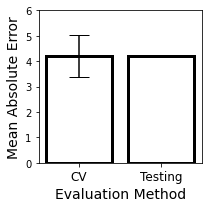

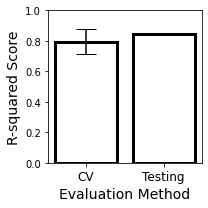

In [ ]:


# Model names for both metrics
model_names = ['CV', 'Testing']
x_pos = np.arange(len(model_names))


# Plot MAE with CV and Testing
plt.figure(figsize=(3, 3))
mae_values = [mean_cv_mae, mae_test]
mae_errors = [std_cv_mae, 0]  # Testing has no error bar

plt.bar(x_pos, mae_values, yerr=mae_errors, color=['white', 'white'], edgecolor='black', linewidth=3, capsize=10)
plt.xlabel('Evaluation Method', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.xticks(x_pos, model_names, fontsize=12)
plt.ylim(0, 6)
plt.tight_layout()
plt.savefig(os.path.join('figures', 'cv_testing_mae.pdf'))
plt.show()

# Plot R² with CV and Testing
plt.figure(figsize=(3, 3))
r2_values = [mean_cv_r2, r2_test]
r2_errors = [std_cv_r2, 0]  # Testing has no error bar

plt.bar(x_pos, r2_values, yerr=r2_errors, color=['white', 'white'], edgecolor='black', linewidth=3, capsize=10)
plt.xlabel('Evaluation Method', fontsize=14)
plt.ylabel('R-squared Score', fontsize=14)
plt.xticks(x_pos, model_names, fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(os.path.join('figures', 'cv_testing_r2.pdf'))
plt.show()

In [ ]:
# Fit the model to the training data
model_CatBoost.fit(data_train[features], data_train[target])

# Get the feature importances
feature_importances = model_CatBoost.feature_importances_

# Convert feature importances to percentages
feature_importances_percentage = 100.0 * (feature_importances / feature_importances.sum())

# Sort feature importances and their corresponding feature names
sorted_idx = feature_importances_percentage.argsort()

0:	learn: 15.4291062	total: 6.36ms	remaining: 4.82s
100:	learn: 5.9198241	total: 166ms	remaining: 1.08s
200:	learn: 4.6467995	total: 306ms	remaining: 849ms
300:	learn: 3.9520515	total: 451ms	remaining: 687ms
400:	learn: 3.4621293	total: 601ms	remaining: 537ms
500:	learn: 3.0899194	total: 750ms	remaining: 386ms
600:	learn: 2.8041576	total: 900ms	remaining: 237ms
700:	learn: 2.5695668	total: 1.05s	remaining: 86.7ms
758:	learn: 2.4382237	total: 1.14s	remaining: 0us


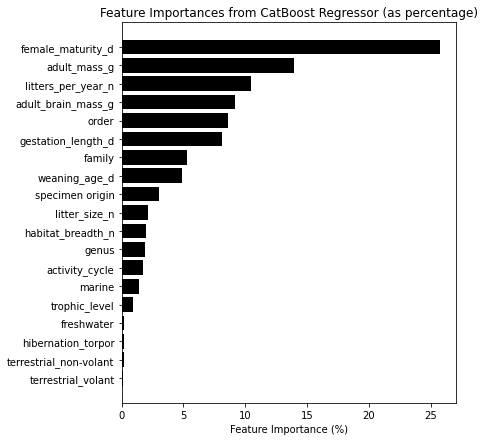

Feature Importances (High to Low):
female_maturity_d: 25.77%
adult_mass_g: 13.97%
litters_per_year_n: 10.49%
adult_brain_mass_g: 9.14%
order: 8.63%
gestation_length_d: 8.12%
family: 5.26%
weaning_age_d: 4.91%
specimen origin: 3.01%
litter_size_n: 2.14%
habitat_breadth_n: 1.99%
genus: 1.86%
activity_cycle: 1.76%
marine: 1.39%
trophic_level: 0.95%
freshwater: 0.18%
hibernation_torpor: 0.17%
terrestrial_non-volant: 0.16%
terrestrial_volant: 0.11%


In [ ]:

# Plot feature importances as percentages
plt.figure(figsize=(6, 7))
plt.barh(np.array(features)[sorted_idx], feature_importances_percentage[sorted_idx], color='black')
plt.xlabel('Feature Importance (%)')
plt.title('Feature Importances from CatBoost Regressor (as percentage)')

# Save the figure to the 'Figures' folder
plt.savefig(os.path.join('figures', 'catboost_feature_importances.pdf'), bbox_inches="tight")
plt.show()

# Order feature importances from high to low
sorted_indices = np.argsort(feature_importances_percentage)[::-1]  # Sort in descending order

# Print feature importances with percentages in descending order
print("Feature Importances (High to Low):")
for feature, importance in zip(np.array(features)[sorted_indices], feature_importances_percentage[sorted_indices]):
    print(f"{feature}: {importance:.2f}%")

In [ ]:
import shap

# Explain the model
explainer = shap.TreeExplainer(model_CatBoost)
shap_values = explainer.shap_values(X)

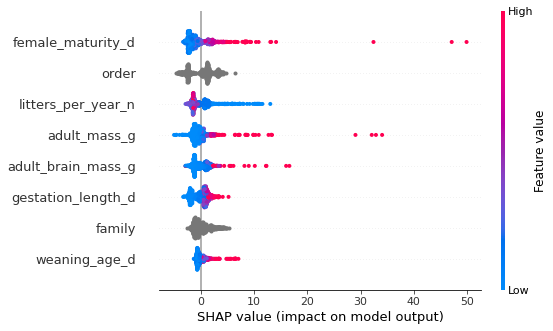

In [ ]:
# Select only some features
selected_features = ["female_maturity_d", "litters_per_year_n", "adult_mass_g",
                     "order", "gestation_length_d", "adult_brain_mass_g", "weaning_age_d", "family"]

# Filter the dataset
X_selected = X[selected_features]

# Filter the corresponding SHAP values
shap_values_selected = shap_values[:, [X.columns.get_loc(f) for f in selected_features]]

# Now plot only for the selected features
shap.summary_plot(shap_values_selected, X_selected, show=False)
plt.savefig("figures/shap_summary_85percent.pdf")
plt.show()